In [1]:
# ==========================================
# 1. SETUP & IMPORTS
# ==========================================
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import EfficientNetB0
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import zipfile
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Install necessary utilities
!pip install split-folders keras-tuner
import splitfolders
import keras_tuner as kt

print("✅ Environment ready for Transfer Learning.")

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 3.6 MB/s eta 0:00:00
✅ Environment ready for Transfer Learning.


In [2]:
# ==========================================
# 2. UNZIP & SPLITTING (Variety Dataset)
# ==========================================
zip_path = '/content/drive/MyDrive/Dataset.zip'
extract_path = '/content/betel_raw'
source_folder = '/content/betel_raw/Dataset' # Path containing the variety folders
output_folder = '/content/betel_final'

# Clean and Extract
if os.path.exists(extract_path): shutil.rmtree(extract_path)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Split into 70% Train, 15% Val, 15% Test
if os.path.exists(output_folder): shutil.rmtree(output_folder)
splitfolders.ratio(source_folder, output=output_folder, seed=42, ratio=(.7, .15, .15))

print(f"✅ Data split successfully. Classes: {os.listdir(os.path.join(output_folder, 'train'))}")

Copying files: 1868 files [00:08, 221.27 files/s]

✅ Data split successfully. Classes: ['Galdalu', 'Mahaneru']


In [3]:
# ==========================================
# 3. DATA PREPROCESSING
# ==========================================
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Training with Augmentation + EfficientNet Preprocessing
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=keras.applications.efficientnet.preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

# Val/Test (Only Preprocessing)
val_test_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=keras.applications.efficientnet.preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    '/content/betel_final/train',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    '/content/betel_final/val',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    '/content/betel_final/test',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
)

class_names = list(train_generator.class_indices.keys())

Found 1307 images belonging to 2 classes.
Found 279 images belonging to 2 classes.
Found 282 images belonging to 2 classes.


In [4]:
# ==========================================
# 4. TUNING THE MODEL HEAD
# ==========================================
def build_transfer_model(hp):
    # Load frozen base model
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(hp.Int('dense_units', 128, 512, step=128), activation='relu'),
        layers.Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=optimizers.Adam(hp.Choice('learning_rate', [1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_transfer_model,
    objective='val_accuracy',
    max_trials=3,
    directory='tuning_dir',
    project_name='betel_effnet'
)

tuner.search(train_generator, epochs=5, validation_data=val_generator)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 3 Complete [00h 10m 55s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 33m 03s


In [5]:
# ==========================================
# 5. TRAINING & SAVING BEST MODEL
# ==========================================
model = tuner.hypermodel.build(best_hps)

# Callbacks
model_callbacks = [
    callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    callbacks.ModelCheckpoint('best_effnet_variety.h5', monitor='val_accuracy', save_best_only=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]

print("🚀 Starting EfficientNet Transfer Learning...")
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=model_callbacks
)

🚀 Starting EfficientNet Transfer Learning...
Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8924 - loss: 0.2988

41/41 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - accuracy: 0.8935 - loss: 0.2958 - val_accuracy: 0.9821 - val_loss: 0.0761 - learning_rate: 1.0000e-04
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9980 - loss: 0.0331

41/41 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.9980 - loss: 0.0330 - val_accuracy: 0.9892 - val_loss: 0.0415 - learning_rate: 1.0000e-04
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 0.0134

41/41 ━━━━━━━━━━━━━━━━━━━━ 119s 3s/step - accuracy: 1.0000 - loss: 0.0134 - val_accuracy: 0.9964 - val_loss: 0.0317 - learning_rate: 1.0000e-04
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 122s 3s/step - accuracy: 1.0000 - loss: 0.0099 - val_accuracy: 0.9964 - val_loss: 0.0241 - learning_rate: 1.0000e-04
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 0.0043

41/41 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 1.0000 - val_loss: 0.0192 - learning_rate: 1.0000e-04
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 119s 3s/step - accuracy: 0.9983 - loss: 0.0054 - val_accuracy: 1.0000 - val_loss: 0.0153 - learning_rate: 1.0000e-04
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 0.0145 - learning_rate: 1.0000e-04
Epoch 8/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 0.0130 - learning_rate: 1.0000e-04
Epoch 9/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 0.0097 - learning_rate: 1.0000e-04
Epoch 10/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 0.0094 - learning_rate: 1.0000e-04
Epoch 11/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 122s 3s/step - accuracy: 1.0000 - loss: 0

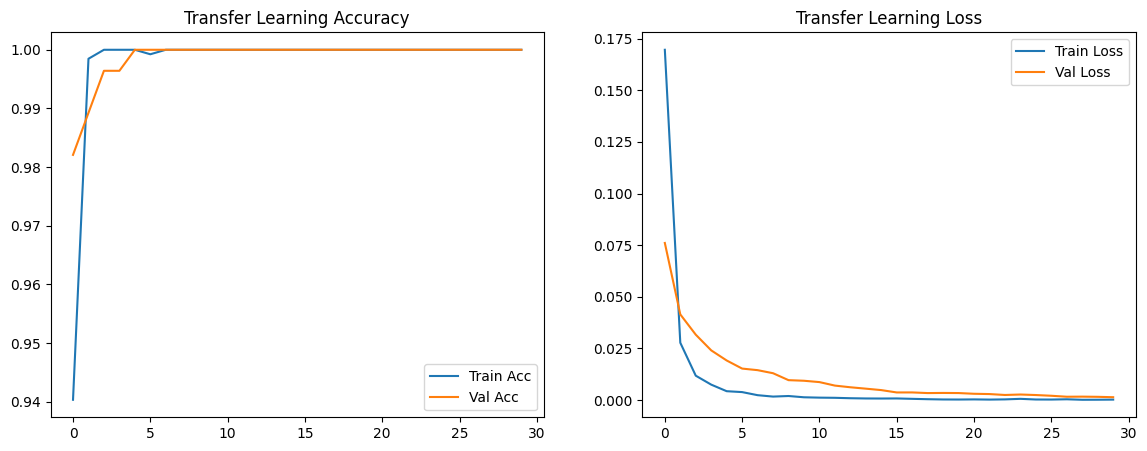

9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 1.0000 - loss: 0.0033

🎯 TRANSFER LEARNING TEST ACCURACY: 100.00%
9/9 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step

📋 Variety Classification Report:
              precision    recall  f1-score   support

     Galdalu       1.00      1.00      1.00        38
    Mahaneru       1.00      1.00      1.00       244

    accuracy                           1.00       282
   macro avg       1.00      1.00      1.00       282
weighted avg       1.00      1.00      1.00       282



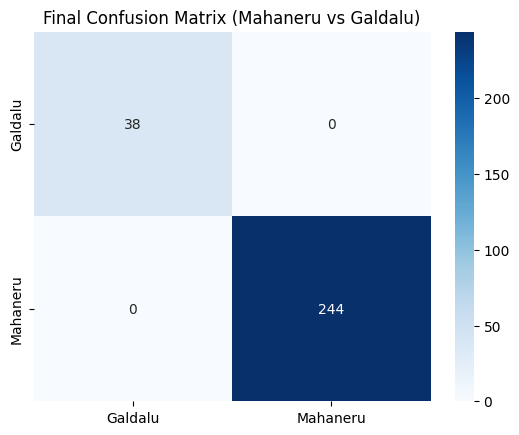

In [6]:
# ==========================================
# 6. PERFORMANCE GRAPHS & SUMMARY
# ==========================================
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Transfer Learning Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Transfer Learning Loss')
plt.legend()
plt.show()

# Final Test set evaluation
test_loss, test_acc = model.evaluate(test_generator)
print(f"\n🎯 TRANSFER LEARNING TEST ACCURACY: {test_acc*100:.2f}%")

# Confusion Matrix
Y_pred = model.predict(test_generator)
y_pred = (Y_pred > 0.5).astype(int).flatten()

print("\n📋 Variety Classification Report:")
print(classification_report(test_generator.classes, y_pred, target_names=class_names))

cm = confusion_matrix(test_generator.classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Final Confusion Matrix (Mahaneru vs Galdalu)')
plt.show()